# Quel effet de l'encadrement des loyers sur les prix de l'immobilier ? 


# Introduction 

Ce projet Python s'inscrit dans le cadre du débat public existant autour de l'efficacité économique de l'instauration de l'encadrement des loyers dans certaines agglomérations (Paris, Lyon, Bordeaux...) considérées comme "zones tendues". Ces villes sont en effet caractérisées par un déséquilibre entre offre et demande de logements et un prix des loyers croissant. 
Dans un [article publié en 2019 dans _American Economic Review_](https://www.aeaweb.org/articles?id=10.1257/aer.20181289) , des chercheurs de l'Université de Stanford ont modélisé les effets de l'introduction d'un contrôle des loyers à San Francisco dans les années 1990. Leurs recherches démontrent que cette mesure n'est pas sans conséquence économique sur le parc immobilier de la ville. Elle est en effet à l'origine une forte baisse de l'offre locative mais également d'une mobilité des habitants moindre avec un renouvellement résidentiel plus faible du parc locatif.

Quel est alors l'effet de l'encadrement des loyers sur les prix de l'immobilier ? 

L'objectif principal de notre travail est également d'étudier plus largement, à partir des bases de données DVF et Filosofi de l'INSEE, les effets de cette politique du logement, très souvent discutée dans le débat politique, sur l'évolution des prix moyens et médians d'achat et l'offre de transactions immobilières. En effet, la relation intrinsèque entre encadrement des loyers et évolution des tendances sur le marché immobilier semble relativement complexe et dépendante de nombreux facteurs sociaux, économiques et politiques. On peut en effet supposer que du fait de la réduction des revenus locatifs engendrée par l'encadrement des loyers, les investisseurs anticipent des rendements plus faibles et sont donc moins enclins à acheter des biens immobiliers, ce qui pourrait réduire les prix ou du moins réduire leur vitesse d'accroissement. Par ailleurs, il est également possible d'émettre l'hypothèse que les investisseurs se reportent alors vers des zones non soumises à encadrement, augmentant alors potentiellement la demande et le prix dans ces zones.  

Par l'application d'un modèle "difference-in-difference" sur différentes zones géographiques soumises et non soumises à l'encadrement des loyers et la réalisation de statistiques descriptives, nous souhaitons donc voir si il est possible de véritablement mesurer ces évolutions et finalement d'infirmer ou confirmer ces hypothèses aux effets contraires en identifiant les effets de l'encadrement des loyers sur les prix de l'immobilier. 

# Installation 

In [1]:
!pip install py7zr geojson geopandas openpyxl tqdm s3fs
!pip install PyYAML xlrd
!pip install git+https://github.com/inseefrlab/cartiflette

  Cloning https://github.com/inseefrlab/cartiflette to /tmp/pip-req-build-e1mq0mlq
  Running command git clone --filter=blob:none --quiet https://github.com/inseefrlab/cartiflette /tmp/pip-req-build-e1mq0mlq
  Resolved https://github.com/inseefrlab/cartiflette to commit f6b0c5d049bd6dcae7b437bd931957371da24278
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import pandas as pd
import numpy as np
import geopandas as gpd
import geojson
import requests
import time
import os
import re
import magic
import matplotlib.pyplot as plt
import zipfile
import cartiflette
from io import StringIO
import statsmodels.formula.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV

This is an experimental version of cartiflette published on PyPi.
To use the latest stable version, you can install it directly from GitHub with the following command:
pip install git+https://github.com/inseeFrLab/cartiflette.git


## I. Importation des données DVF

### A. Paramétrage de l'API

On commence d'abord par paramétrer l'API pour pouvoir importer les données DVF.

On écrit la racine de l'API : 

In [ ]:
base_api_dvf_url = "https://apidf-preprod.cerema.fr"
global base_api_dvf_url

On souhaite réaliser notre étude comparative sur deux zones : l'ouest et le sud parisien. Dans chaque zones, on veut a besoin d'un groupe traitement : celui où il y a eu encadrement des loyers, c'est-à-dire les arrondissements parisiens. On a aussi besoin d'un groupe contrôle, c'est-à-dire qui n'a pas connu d'encadrement des loyers, de préférence le plus similaire au groupe traitement. On choisit pour cela les villes de banlieues immédiatement contiguës aux arrondissements. Au total, on souhaite donc récupérer les données DVF des villes suivantes : 
1. **Zone ouest** :
- Paris 16 : 75116
- Paris 17: 75117 ; l'encadrement des loyers est appliqué dans ces 2 arrondissements depuis 2019.
- Clichy : 92024
- Levallois : 92044
- Neuilly : 92051
- Boulogne-Billancourt : 92012

2. **Zone sud**
- Paris 13 : 75113
- Paris 14 : 75114
- Paris 15 : 75115 ;  l'encadrement des loyers est appliqué dans ces 3 arrondissements depuis 2019.
- Issy-les-Moulineaux : 92040
- Vanves : 92075
- Malakoff : 92046
- Montrouge : 92049
- Gentilly : 94037
- Ivry-sur-Seine : 94041


On peut essayer de faire tourner naïvement l'API pour récupérer les données pour Issy-les-Moulineaux (92040).

In [ ]:
code_insee = 92040
url = base_api_dvf_url + f"/dvf_opendata/geomutations/?code_insee={code_insee}&page_size=500"
response = requests.get(url)
data = response.json()
print(data)
cleaning_json_for_gpd(data)
mut_gdf = gpd.GeoDataFrame.from_features(data["features"])
print(len(mut_gpf))

On constate en faisant tourner naïvement l'API qu'on obtient toujours des données par paquets en nombre limité (par défaut, 100). On peut modifier cela par le paramètre "page_size", mais la limite est de 500. Pour un paramètre supérieur à 500, on n'obtient que des pages de 500. 

On cherche donc à faire boucler nos requêtes à l'API jusqu'à obtenir toutes les données concernant la commune qui nous intéresse. Or on constate que la réponse "data" que l'on obtient possède une clé "next", qui donne l'url de notre requête complété par un argument "page". L'API fonctionne donc ainsi : s'il y a plus de 500 observations pour une commune, l'API nous renvoie une première page qui contient 500 observations, avec l'url pour requêter la page suivant qui contient 500 autres observations, et ainsi de suite jusqu'à la dernière page, qui donne pour valeur "None" à la clé "next". 

Le code ci-dessous permet de récupérer les données pour toutes les villes et arrondissement de la zone sud. Attention, veuillez lire la cellule de texte suivante si l'éxécution de ce code prend trop de temps !

In [ ]:
"""data_dvf_sud = recup_donnees_dvf_all_years("92040") 

code_insee_sud = ["92075", "92046", "92049", "94037", "94041", "75113", "75114", "75115"]

for code_insee_ville in code_insee_sud: 
    print(code_insee_ville)
    data_temp = recup_donnees_dvf_all_years(code_insee_ville)
    data_dvf_sud = pd.concat([data_dvf_sud, data_temp], axis = 0)

data_dvf_sud.shape"""

'data_dvf_sud = recup_donnees_dvf_all_years("92040") \n\ncode_insee_ville_banlieue_sud = ["92075", "92046", "92049", "94037", "94041"]\ncode_insee_arrond_sud = ["75113", "75114", "75115"]\n\nfor code_insee_ville in code_insee_ville_banlieue_sud: \n    print(code_insee_ville)\n    data_temp = recup_donnees_dvf_all_years(code_insee_ville)\n    data_dvf_sud = pd.concat([data_dvf_sud, data_temp], axis = 0)\n\ndata_dvf_sud.shape'

On pourrait écrire la même chose pour la zone ouest, mais difficulté : l'API peut arrêter de nous répondre de manière imprévue au milieu de la boucle de requête des pages. Dans ce cas, toutes les données obtenues sur les pages précédentes sont perdues. On a donc intérêt, pour pouvoir travailler sereinement, à télécharger ces données. 

Pour ce faire, on va essayer, commune par commune, de requêter toutes les pages, et, AVANT de passer au requêtage pour la commune suivante, on sauvegarde notre geodataframe au format geojson. On inscrit donc le code INSEE de toutes les communes dont on veut récupérer les données dans la liste "pour_enregistrer", et à chaque fois qu'un fichier pour une commune est téléchargé, on supprime son code INSEE de la liste. 

On propose ici un exemple avec seulement le code INSEE 92012, pour montrer que le code fonctionne.

In [8]:
"""code_insee_pour_enregistre = ["92012"]
for code_insee in code_insee_pour_enregistre: 
    url = base_api_dvf_url + f"/dvf_opendata/geomutations/?code_insee={code_insee}&page_size=100"
    response = requests.get(url)
    data = response.json()
    print(data['count'])
    gdf = recup_donnees_dvf_all_years(code_insee)
    name = f'data/dvf/data_code_insee={code_insee}.geojson'
    gdf.to_file(name, driver="GeoJSON")
    gdf = gpd.read_file(name)
    print(len(gdf))"""

'code_insee_pour_enregistre = ["92012"]\nfor code_insee in code_insee_pour_enregistre: \n    url = base_api_dvf_url + f"/dvf_opendata/geomutations/?code_insee={code_insee}&page_size=100"\n    response = requests.get(url)\n    data = response.json()\n    print(data[\'count\'])\n    gdf = recup_donnees_dvf_all_years(code_insee)\n    name = f\'data/dvf/data_code_insee={code_insee}.geojson\'\n    gdf.to_file(name, driver="GeoJSON")\n    gdf = gpd.read_file(name)\n    print(len(gdf))'

Ci-dessous, le code pour reconstituer les fichiers geojson à partir des sauvegardes faites à cause de l'API défectueuse (en deux temps : la zone ouest puis la zone sud)

In [11]:
obs_tot = 0
list_gpd_ouest = []
for geo_file in os.listdir("data/dvf/cluster_ouest"): 
    geo_file_temp = gpd.read_file("data/dvf/cluster_ouest/"+geo_file)  
    list_gpd_ouest.append(geo_file_temp)
    obs_tot += len(geo_file_temp)

all_gpd_ouest = pd.concat(list_gpd_ouest)
print(len(all_gpd_ouest), obs_tot)

134410 134410


In [ ]:
obs_tot = 0
list_gpd_sud = []
for geo_file in os.listdir("data/dvf/cluster_sud"): 
    geo_file_temp = gpd.read_file("data/dvf/cluster_sud/"+geo_file)  
    obs_tot += len(geo_file_temp)
    list_gpd_sud.append(geo_file_temp)

all_gpd_sud = pd.concat(list_gpd_sud)
print(len(all_gpd_sud), obs_tot) 

119319 119319


L'importation des données DVF est donc terminée.

### B- Description des variables de ce dataframe :
- idmutinvar = identifiant unique entre les diff bases pour retrouver chaque mutation
- idopendata = identifiant de mutation utilisé depuis l'ouverture de données DVF
- datemut = date de signature de l'acte de vente
- anneemut = annee de signature du doc
- codedep
- libnatmut = Libellé de nature de mutation tel que défini dans la donnée source DVF 6 catégories : Vente, Vente en l'état futur d'achèvement, Adjudication, Echange, Vente terrain à bâtir et Expropriation.
- vefa = booléen selon si la vente est en VEFA (vente en l'état futur d'achèvement) ou non
- valeurfonc = valeur foncière en euro déclarée lors de la vente ; prix net vendeur, inclut la TVA mais n'inclut pas les frais de notaire, d'agence ou des meubles. 
- nbcomm = nombre de communes concernée par la mutation (i.e. sur lesquelles se trouve la parcelle cadastrale concernée par la mutation)
- nbpar = comme nbcomm mais pour les parcelles.
- nbparmut = nb de parcelles ayant muté (i.e. dont la pleine propriété a été transférée lors de la mutation)
- sterr = surface de terrain ayant muté (mutation = transfert de propriété, donc surface de terrain ayant muté = surface du terrain qui a été vendu)
- nbvolmut = variable obscure, flemme 
- nblocmut = nb de locaux ayant muté
- sbati = surface de l'ensemble du bati ayant muté
- codtypbien = typologie des biens ; on pourra s'en servir pour filter les maisons et appartements et virer tous les types de batiments bizarres (cf schéma ici) https://doc-datafoncier.cerema.fr/doc/dv3f/mutation/codtypbien
- libtypbien = comme codtypbien mais pour la base DV3F et non issu de juste DVF
- geometry
- l_codeinsee = liste des codes INSEE des communes concernées par la mutation
- l_idpar =Liste des idpar qui composent l’entité (idpar = Identifiant de parcelle)
- l_idparmut = liste des identifiants de parcelles ayant muté (idpar)
- l_idlocmut = liste des identifiants de locaux ayant muté (idloc)

## II. Récupération de données Insee par IRIS pour avoir des variables de contrôle dans notre régression

Il n'y a pas d'API permettant de récupérer les données voulues par IRIS, donc on doit passer par l'importation de tous les fichiers en format csv. On importe trois types de fichiers : un qui contient des informations sur le revenu disponible ('BASE_TD_FILO_DISP_IRIS'), un qui donne des informations sur les logements ('base_ic_logement') et un sur les occupations professionnelles des habitants de l'IRIS ('base-ic-activite-residents').

On va maintenant ouvrir tous ces fichiers importés : 

In [ ]:
dfs_activite = []
dfs_logement = []
dfs_revenu = []
dates_df = []


for f in os.listdir("data/insee"):
    if f.lower().endswith(".zip"): #si c'est un zip
        print(f)
        zip_file = zipfile.ZipFile("data/insee/"+f) #on le dézipe
        nom_racine_dossier = f.rsplit(".",1)[0]
        for f_in_zip in zipfile.ZipFile("data/insee/"+f).namelist():
            if f_in_zip[0:4] == "meta" :
                pass
            else :
                nom_racine_fichier = f_in_zip.rsplit(".",1)[0]
                extension = f_in_zip.rsplit(".",1)[1] #on récupère l'extension
                
                # Recherche de l'année
                schema_date = r"(\d{4})"
                match = re.search(schema_date, f)
                    
                annee_extraite = match.group(1)
                
                if extension.lower() == "csv":
                    df_temp = pd.read_csv(zip_file.open(nom_racine_fichier + "." + extension), 
                                            sep = ";", dtype = {'IRIS' : str})
                                            
                elif extension in ("xls", "xlsx"):
                    df_temp = pd.read_excel(zip_file.open(nom_racine_fichier + "." + extension),
                                            skiprows = 5, dtype = {'IRIS' : str})
                    
                df_temp['IRIS'] = df_temp['IRIS'].apply(lambda x: '0' + x if len(x) == 8 else x)
                
                deux_derniers_chiffres_annee = annee_extraite[2:4]
                df_temp['annee'] = annee_extraite
                
                if "activite" in nom_racine_fichier:
                    df_temp.columns = [col.replace(f'{deux_derniers_chiffres_annee}_', '_') for col in df_temp.columns]
                    dfs_activite.append(df_temp)
                elif "logement" in nom_racine_fichier:
                    df_temp.columns = [col.replace(f'{deux_derniers_chiffres_annee}_', '_') for col in df_temp.columns]
                    dfs_logement.append(df_temp)
                elif "DISP" in nom_racine_fichier:
                    colonnes_a_traiter = [col for col in df_temp.columns if col.endswith(deux_derniers_chiffres_annee)]
                    df_temp = df_temp.rename(columns={col: col[:-2] for col in colonnes_a_traiter})
                    dfs_revenu.append(df_temp)
                else :
                    print('un fichier n a pas été traité')

                dates_df.append(annee_extraite)
    else :
        nom_racine_fichier = f.rsplit(".",1)[0]
        extension = f.rsplit(".",1)[1] #on récupère l'extension
                
        schema_date = r"(\d{4})"
        match = re.search(schema_date, f)     
        annee_extraite = match.group(1)

        df_temp = pd.read_excel("data/insee/" + nom_racine_fichier + "." + extension,
                                            skiprows = 5, dtype = {'IRIS' : str})
                    
        df_temp['IRIS'] = df_temp['IRIS'].apply(lambda x: '0' + x if len(x) == 8 else x)
        deux_derniers_chiffres_annee = annee_extraite[2:4]
        df_temp['annee'] = annee_extraite
                
        if "DISP" in nom_racine_fichier:
            colonnes_a_traiter = [col for col in df_temp.columns if col.endswith(deux_derniers_chiffres_annee)]
            df_temp = df_temp.rename(columns={col: col[:-2] for col in colonnes_a_traiter})
            dfs_revenu.append(df_temp)

        dates_df.append(annee_extraite)


On commence à les traiter et on vérifie qu'on a bien réalisé leur ouverture : 

In [14]:
dfs_clean_activite = pd.concat(dfs_activite, ignore_index = True)
dfs_clean_revenu = pd.concat(dfs_revenu, ignore_index = True)
dfs_clean_logement = pd.concat(dfs_logement, ignore_index = True)

In [15]:
print(dfs_clean_activite.shape)
print(dfs_clean_revenu.shape)
print(dfs_clean_logement.shape)


(395824, 131)
(122018, 36)
(395824, 123)


On finit en les fusionnant en un seul dataframe.

In [16]:
df_fusion_inter = pd.merge(dfs_clean_activite, dfs_clean_revenu,how = "outer", on=['IRIS','annee']) 
df_fusion_all_insee = pd.merge(df_fusion_inter, dfs_clean_logement, how = "outer",on=['IRIS', 'annee'])#, 'LIBIRIS','TYP_IRIS','MODIF_IRIS','LAB_IRIS','COM', 'LIBCOM'])

Vérifions que le dataframe obtenu n'a pas de problème.

In [17]:
print(df_fusion_inter.shape)
print(df_fusion_all_insee.shape)

(411921, 165)
(411921, 286)


## III. Fusion de nos deux jeux de données


Troisième et dernière étape d'importation des données : il nous faut un fichier pour faire la correspondance entre les adresses/coordonnées des données DVF et les IRIS des données Insee.

On utilise un fichier des données géographiques des IRIS d'Île-de-France.

In [18]:
iris = gpd.read_file("data/iris.geojson")  
iris = iris.to_crs(epsg=4326)  # Assurez-vous d'utiliser le même système de coordonnées (WGS84)
iris['code_iris'] = iris['code_iris'].astype(str)

On regarde dans quel système géographique est le tableau geopandas des données DVF

In [19]:
print(all_gpd_sud["geometry"].crs)
print(all_gpd_ouest["geometry"].crs)

EPSG:4326
EPSG:4326


On est bien en format 4326 (=WGS 84) pour les deux fichiers, on va donc pouvoir affecter des IRIS à nos adresses de la base DVF (pour ensuite les relier aux fichiers Insee).

In [ ]:
data_mut_sud_avec_iris = gpd.sjoin(all_gpd_sud, iris, how="left", predicate="intersects")
data_mut_ouest_avec_iris = gpd.sjoin(all_gpd_ouest, iris, how="left", predicate="intersects")

# Vérifier les résultats
print(data_mut_sud_avec_iris.head())
print(data_mut_sud_avec_iris.columns)
print(all_gpd_sud.shape)
print(data_mut_sud_avec_iris.shape)

Les deux codes ci-dessous servent à éliminer les ventes qui sont à cheval entre deux IRIS (on a assez d'observations comme ça et elles pourraient brouiller les résultats de notre modèle).

In [21]:
non_unique_ids_sud = data_mut_sud_avec_iris['idmutinvar'][data_mut_sud_avec_iris['idmutinvar'].duplicated(keep=False)]
data_mut_sud_avec_iris_unique = data_mut_sud_avec_iris[~data_mut_sud_avec_iris['idmutinvar'].isin(non_unique_ids_sud)]
data_mut_sud_avec_iris = data_mut_sud_avec_iris_unique

In [22]:
non_unique_ids_ouest = data_mut_ouest_avec_iris['idmutinvar'][data_mut_ouest_avec_iris['idmutinvar'].duplicated(keep=False)]
data_mut_ouest_avec_iris_unique = data_mut_ouest_avec_iris[~data_mut_ouest_avec_iris['idmutinvar'].isin(non_unique_ids_ouest)]
print(data_mut_ouest_avec_iris.shape)
print(data_mut_ouest_avec_iris_unique.shape)

data_mut_ouest_avec_iris = data_mut_ouest_avec_iris_unique

(140041, 31)
(129306, 31)


On enlève les ventes faites après 2021 car les données Insee s'arrêtent en 2021

In [23]:
data_mut_sud_avec_iris = data_mut_sud_avec_iris[data_mut_sud_avec_iris['anneemut'].astype(int) < 2022]
data_mut_sud_avec_iris.shape

data_mut_ouest_avec_iris = data_mut_ouest_avec_iris[data_mut_ouest_avec_iris['anneemut'].astype(int) < 2022]
data_mut_ouest_avec_iris.shape

(96924, 31)

Dernière étape : relier ça aux données Insee

In [24]:
data_mut_ouest_et_insee = pd.merge(left = data_mut_ouest_avec_iris,
                            right = df_fusion_all_insee, 
                            how = "inner",
                            left_on = ["code_iris", "anneemut"],
                            right_on = ["IRIS", "annee"])

data_mut_sud_et_insee = pd.merge(left = data_mut_sud_avec_iris,
                            right = df_fusion_all_insee, 
                            how = "inner",
                            left_on = ["code_iris", "anneemut"],
                            right_on = ["IRIS", "annee"])
                            

In [25]:
data_mut_ouest_et_insee.shape

(109677, 317)

Ci-dessous, on va regarder les variables des trois jeux de données Insee et vérifier qu'elles sont bien présents dans le jeu de données final (on va regarder sur 2019 car on sait qu'il y a bien pour cette année des données DVF et Insee complètes).

In [26]:
data_mut_ouest_et_insee_2019 = data_mut_ouest_et_insee[data_mut_ouest_et_insee["anneemut"] == "2019"]

In [27]:
dfs_revenu[1].columns

Index(['IRIS', 'DISP_TP60', 'DISP_Q1', 'DISP_MED', 'DISP_Q3', 'DISP_EQ',
       'DISP_D1', 'DISP_D2', 'DISP_D3', 'DISP_D4', 'DISP_D6', 'DISP_D7',
       'DISP_D8', 'DISP_D9', 'DISP_RD', 'DISP_S80S20', 'DISP_GI', 'DISP_PACT',
       'DISP_PTSA', 'DISP_PCHO', 'DISP_PBEN', 'DISP_PPEN', 'DISP_PPAT',
       'DISP_PPSOC', 'DISP_PPFAM', 'DISP_PPMINI', 'DISP_PPLOGT', 'DISP_PIMPOT',
       'DISP_NOTE', 'annee'],
      dtype='object')

In [28]:
dfs_logement[1].columns

Index(['IRIS', 'REG', 'DEP', 'UU2010', 'COM', 'LIBCOM', 'TRIRIS', 'GRD_QUART',
       'LIBIRIS', 'TYP_IRIS',
       ...
       'P_RP_TTEGOU', 'P_RP_GARL', 'P_RP_VOIT1P', 'P_RP_VOIT1', 'P_RP_VOIT2P',
       'P_RP_HABFOR', 'P_RP_CASE', 'P_RP_MIBOIS', 'P_RP_MIDUR', 'annee'],
      dtype='object', length=103)

In [29]:
dfs_activite[1].columns

Index(['IRIS', 'REG', 'DEP', 'UU2010', 'COM', 'LIBCOM', 'TRIRIS', 'GRD_QUART',
       'LIBIRIS', 'TYP_IRIS',
       ...
       'P_ACTOCC15P_ILT3', 'P_ACTOCC15P_ILT4', 'P_ACTOCC15P_ILT5',
       'C_ACTOCC15P', 'C_ACTOCC15P_PAS', 'C_ACTOCC15P_MAR', 'C_ACTOCC15P_DROU',
       'C_ACTOCC15P_VOIT', 'C_ACTOCC15P_TCOM', 'annee'],
      dtype='object', length=115)

In [ ]:
print(data_mut_ouest_et_insee_2019['P_ACTOCC15P_ILT3']) #activite
print(data_mut_ouest_et_insee_2019['P_RP_VOIT1P']) #logement
print(data_mut_ouest_et_insee_2019['DISP_D1']) #revenu

### IV. Nettoyage du jeu de données

Regardons d'abord notre jeu de données :

In [31]:
print(data_mut_ouest_et_insee.shape)

(109677, 317)


On a énormément de colonnes dans ce jeu de données, sont-elles toutes utilisables ?

In [32]:
df_verif = pd.DataFrame(data_mut_ouest_et_insee.isna().sum() / len(data_mut_ouest_et_insee)) 
print(df_verif)

                         0
idmutinvar        0.000000
idopendata        0.000000
datemut           0.000000
anneemut          0.000000
coddep            0.000000
...                    ...
P_RPMAISON_ACH11  0.895940
P_RPAPPART_ACH11  0.895940
P_RP_ACH18        0.868268
P_RPMAISON_ACH18  0.868268
P_RPAPPART_ACH18  0.868268

[317 rows x 1 columns]


Visiblement, certaines colonnes sont presque vides (on affiche ici le pourcentage d'observations manquantes). On va supprimer toutes les colonnes qui ont plus de 10% d'observations manquantes.

In [33]:
df_to_drop = df_verif[df_verif[0] > 0.1]
to_drop = []
for index, row in df_to_drop.iterrows():
    to_drop.append(index)
data_mut_ouest_et_insee = data_mut_ouest_et_insee.drop(to_drop, axis=1)
print(data_mut_ouest_et_insee.shape)

(109677, 237)


Vérifions qu'on a bien enlevé toutes les colonnes vides : 

In [34]:
df_verif = pd.DataFrame(data_mut_ouest_et_insee.isna().sum() / len(data_mut_ouest_et_insee))
df_to_drop = df_verif[df_verif[0] > 0.1]
print(df_to_drop.shape)

(0, 1)


Vérifions aussi que nous avons conservé les variables qui nous intéressaient le plus dans les jeux de données INSEE :

In [35]:
print('P_ACTOCC15P_ILT3' in to_drop)
print('P_RP_VOIT1P' in to_drop)
print('DISP_D1' in to_drop)

False
False
False


Maintenant qu'on a épuré les colonnes, on peut regarder les lignes. Il faut enlever toutes les transactions qui ne nous intéressent pas. En particulier, certaines transactions affichent une surface batie vendue de 0 ET une surface de terrain vendue de 0. D'autres transactions présentent une valeur de vente de 0. 

In [36]:
df_ouest = data_mut_ouest_et_insee
df_ouest['valeurfonc']  = df_ouest["valeurfonc"].astype(float)
df_ouest['sbati']  = df_ouest["sbati"].astype(float)
df_ouest['sterr']  = df_ouest["sterr"].astype(float)
df_ouest['stot']  = df_ouest["sterr"] + df_ouest["sbati"]


In [37]:
print(len(df_ouest))
df_ouest = df_ouest[df_ouest['stot']>0]
df_ouest = df_ouest[df_ouest['valeurfonc']>0]
print(len(df_ouest))

109677
89989


On va également s'assurer que les transactions ne concernent que des maisons ou des appartements (voire la documentation).

In [38]:
df_ouest = df_ouest[df_ouest["codtypbien"].str.startswith(('11', "12"))]
print(len(df_ouest))

83030


In [39]:
biens_retenus = ['UN APPARTEMENT', 'UNE MAISON']
df_ouest = df_ouest[df_ouest['libtypbien'].isin(biens_retenus)]
print(len(df_ouest))

77753


In [40]:
data_mut_ouest_et_insee = df_ouest

On va répéter exactement la même chose pour la zone sud : 

In [41]:
print(data_mut_sud_et_insee.shape)
df_sud = data_mut_sud_et_insee
df_verif = pd.DataFrame(data_mut_sud_et_insee.isna().sum() / len(data_mut_sud_et_insee)) 
df_to_drop = df_verif[df_verif[0] > 0.1]
to_drop = []
for index, row in df_to_drop.iterrows():
    to_drop.append(index)
data_mut_sud_et_insee = data_mut_sud_et_insee.drop(to_drop, axis=1)
df_sud = data_mut_sud_et_insee
print('P_ACTOCC15P_ILT3' in to_drop)
print('P_RP_VOIT1P' in to_drop)
print('DISP_D1' in to_drop)
df_sud['valeurfonc']  = df_sud["valeurfonc"].astype(float)
df_sud['sbati']  = df_sud["sbati"].astype(float)
df_sud['sterr']  = df_sud["sterr"].astype(float)
df_sud['stot']  = df_sud["sterr"] + df_ouest["sbati"]
df_sud = df_sud[(df_sud['stot']>0) & (df_sud['valeurfonc']>0)]
df_sud = df_sud[df_sud["codtypbien"].str.startswith(('11', "12"))]
df_sud = df_sud[df_sud['libtypbien'].isin(biens_retenus)]
data_mut_sud_et_insee = df_sud
print(data_mut_sud_et_insee.shape)

(95139, 317)
False
False
False
(50341, 238)


# Visualisation

On commence à faire vite-fait un peu de visualisation spatiale

In [42]:
"""idf = cartiflette.carti_download(
    values=["11"],
    crs=4326,
    borders="DEPARTEMENT",
    vectorfile_format="geojson",
    filter_by="REGION",
    source="EXPRESS-COG-CARTO-TERRITOIRE",
    year=2022,
)

departements_paris_92 = idf.loc[
    idf["INSEE_DEP"].isin(["75", "92"])
].to_crs(2154)

fig, ax = plt.subplots(figsize=(12, 12))
base = departements_paris_92.boundary.plot(ax=ax, edgecolor="black", linewidth=0.5, figsize=(10, 10))

data_mut_et_insee_pour_vis = data_mut_ouest_et_insee
data_mut_et_insee_pour_vis["geometry"] = data_mut_et_insee_pour_vis["geometry"].to_crs(2154)

data_mut_et_insee_pour_vis.plot(ax=ax)

plt.show()

"""

'idf = cartiflette.carti_download(\n    values=["11"],\n    crs=4326,\n    borders="DEPARTEMENT",\n    vectorfile_format="geojson",\n    filter_by="REGION",\n    source="EXPRESS-COG-CARTO-TERRITOIRE",\n    year=2022,\n)\n\ndepartements_paris_92 = idf.loc[\n    idf["INSEE_DEP"].isin(["75", "92"])\n].to_crs(2154)\n\nfig, ax = plt.subplots(figsize=(12, 12))\nbase = departements_paris_92.boundary.plot(ax=ax, edgecolor="black", linewidth=0.5, figsize=(10, 10))\n\ndata_mut_et_insee_pour_vis = data_mut_ouest_et_insee\ndata_mut_et_insee_pour_vis["geometry"] = data_mut_et_insee_pour_vis["geometry"].to_crs(2154)\n\ndata_mut_et_insee_pour_vis.plot(ax=ax)\n\nplt.show()\n\n'

On a sélectionné ici au début du code les villes de Vanves et Issy les Moulineaux, d'où le fait que les tâches de couleur s'affichent sur une zone localisée (uniquement les villes concernées)
= > il faudra ajuster l'API et le fond de carte selon la commune choisie, mais au moins on sait le faire fonctionner grosso modo

Isaure: On veut réaliser une carte interactive indiiquant le prix au mètre carré de chaque transactions sur la carte, on crée donc cette variable dans notre data_frame.

In [43]:
# Calcul de prix_m2
data_mut_ouest_et_insee['prix_m2'] = data_mut_ouest_et_insee['valeurfonc'] / data_mut_ouest_et_insee['sbati']


On convertit toutes les géométries de multipolygon à point

In [44]:

print(data_mut_ouest_et_insee.geometry.geom_type.unique())

data_mut_ouest_et_insee['geometry'] = data_mut_ouest_et_insee.geometry.centroid

print(data_mut_ouest_et_insee.geometry.geom_type.unique())



['MultiPolygon']
['Point']


/tmp/ipykernel_330746/2684490348.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  data_mut_ouest_et_insee['geometry'] = data_mut_ouest_et_insee.geometry.centroid


On convertit la géométrie en données WGS 84 (coordonnées gps classiques) pour pouvoir la bibliothèque Folium de Python

In [45]:

data_mut_ouest_et_insee = data_mut_ouest_et_insee.to_crs(epsg=4326)
print(data_mut_ouest_et_insee[['geometry']].head())


                   geometry
1  POINT (2.31817 48.88951)
2  POINT (2.31219 48.88438)
4  POINT (2.32185 48.88883)
6   POINT (2.3234 48.88493)
7  POINT (2.32573 48.89291)


on veut des cartes seulement pour 2019, 2020 et 2021.

In [46]:
data_mut_ouest_et_insee['annee'] = data_mut_ouest_et_insee['datemut'].dt.year

annees_interet = [2019, 2020, 2021]
data_filtre_annees = data_mut_ouest_et_insee[data_mut_ouest_et_insee['annee'].isin(annees_interet)]


print(data_filtre_annees[['annee', 'prix_m2', 'geometry']].head())



   annee       prix_m2                  geometry
1   2021  15033.333333  POINT (2.31817 48.88951)
2   2021  14035.600000  POINT (2.31219 48.88438)
4   2021  11244.736842  POINT (2.32185 48.88883)
6   2021  11091.025974   POINT (2.3234 48.88493)
7   2021   9852.941176  POINT (2.32573 48.89291)


In [47]:
# Filtrer les données par année
data_2019 = data_mut_ouest_et_insee[data_mut_ouest_et_insee['datemut'].dt.year == 2019]
data_2020 = data_mut_ouest_et_insee[data_mut_ouest_et_insee['datemut'].dt.year == 2020]
data_2021 = data_mut_ouest_et_insee[data_mut_ouest_et_insee['datemut'].dt.year == 2021]

print(f"2019 : {len(data_2019)}, 2020 : {len(data_2020)}, 2021 : {len(data_2021)}")


2019 : 10911, 2020 : 17746, 2021 : 10296


On crée une première carte avec des points en la centrant directement avec location = (48.89, 2.29), j'ai pris Levallois Perret

In [48]:
"""
import folium

# Fonction pour créer une carte
def create_map(data, year):
    m = folium.Map(location=[48.8918307474864, 2.292034072558762], zoom_start=16)  # Coordonnées centrées sur Paris
    for _, row in data.iterrows():
        folium.CircleMarker(
            location=[row.geometry.y, row.geometry.x],
            radius=5,
            color='blue',
            fill=True,
            fill_color='blue',
            fill_opacity=0.7,
            popup=f"Prix m² : {row['prix_m2']:.2f} €\nDate : {row['datemut']}"
        ).add_to(m)
    return m


carte_2019 = create_map(data_2019, 2019)
carte_2020 = create_map(data_2020, 2020)
carte_2021 = create_map(data_2021, 2021)

carte_2019
"""

'\nimport folium\n\n# Fonction pour créer une carte\ndef create_map(data, year):\n    m = folium.Map(location=[48.8918307474864, 2.292034072558762], zoom_start=16)  # Coordonnées centrées sur Paris\n    for _, row in data.iterrows():\n        folium.CircleMarker(\n            location=[row.geometry.y, row.geometry.x],\n            radius=5,\n            color=\'blue\',\n            fill=True,\n            fill_color=\'blue\',\n            fill_opacity=0.7,\n            popup=f"Prix m² : {row[\'prix_m2\']:.2f} €\nDate : {row[\'datemut\']}"\n        ).add_to(m)\n    return m\n\n\ncarte_2019 = create_map(data_2019, 2019)\ncarte_2020 = create_map(data_2020, 2020)\ncarte_2021 = create_map(data_2021, 2021)\n\ncarte_2019\n'

Pour une visualisation plus aérée et lisible, on prend un échantillon aléatoire de 10% des des données.

In [49]:

reduced_data = data_mut_ouest_et_insee.sample(frac=0.1, random_state=42)


On fait une nouvelle carte avec des clusters

In [50]:
"""from folium.plugins import MarkerCluster

m = folium.Map(location=[48.8918307474864, 2.29], zoom_start=16)
marker_cluster = MarkerCluster().add_to(m)

for _, row in reduced_data.iterrows():
    folium.Marker(
        location=[row.geometry.y, row.geometry.x],
        popup=f"Prix m² : {row['prix_m2']:.2f} €<br>Type : {row['libtypbien']}",
    ).add_to(marker_cluster)

m
"""

'from folium.plugins import MarkerCluster\n\nm = folium.Map(location=[48.8918307474864, 2.29], zoom_start=16)\nmarker_cluster = MarkerCluster().add_to(m)\n\nfor _, row in reduced_data.iterrows():\n    folium.Marker(\n        location=[row.geometry.y, row.geometry.x],\n        popup=f"Prix m² : {row[\'prix_m2\']:.2f} €<br>Type : {row[\'libtypbien\']}",\n    ).add_to(marker_cluster)\n\nm\n'

# Analyse et statistiques descriptives : 

In [51]:
print(data_mut_ouest_et_insee['libtypbien'].unique())


['UN APPARTEMENT' 'UNE MAISON']


/opt/conda/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


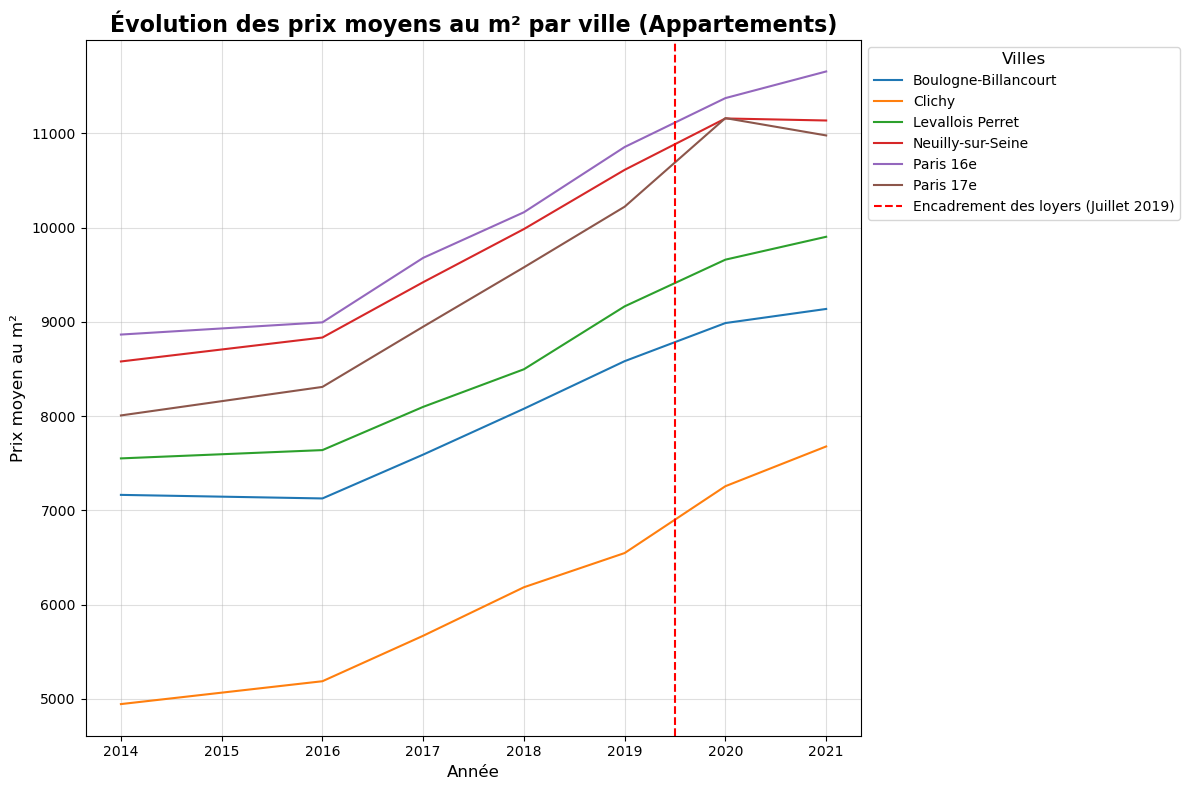

In [52]:


import matplotlib.pyplot as plt

appartements = data_mut_ouest_et_insee[data_mut_ouest_et_insee['libtypbien'] == 'UN APPARTEMENT']

# Dictionnaire de correspondance correct entre codes INSEE et noms des villes
insee_to_ville = {
    "75116": "Paris 16e",
    "75117": "Paris 17e",
    "92012": "Boulogne-Billancourt",
    "92024": "Clichy",
    "92044": "Levallois Perret",
    "92051": "Neuilly-sur-Seine"
}


appartements['nom_ville'] = appartements['l_codinsee'].map(insee_to_ville)


stats_par_ville = appartements.groupby(['annee', 'nom_ville'])['prix_m2'].mean().reset_index()


plt.figure(figsize=(12, 8))
for ville in stats_par_ville['nom_ville'].unique():
    subset = stats_par_ville[stats_par_ville['nom_ville'] == ville]
    plt.plot(subset['annee'], subset['prix_m2'], label=ville)


plt.axvline(x=2019.5, color='red', linestyle='--', linewidth=1.5, label="Encadrement des loyers (Juillet 2019)")


plt.title("Évolution des prix moyens au m² par ville (Appartements)", fontsize=16, fontweight='bold')
plt.xlabel("Année", fontsize=12)
plt.ylabel("Prix moyen au m²", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title="Villes", fontsize=10, title_fontsize=12, loc='upper left', bbox_to_anchor=(1, 1))  # Légende à l'extérieur
plt.grid(alpha=0.4)
plt.tight_layout()  
plt.show()




In [53]:
# Calcul de prix_m2
data_mut_sud_et_insee['prix_m2'] = data_mut_sud_et_insee['valeurfonc'] / data_mut_sud_et_insee['sbati']


In [54]:
import matplotlib.pyplot as plt

# Filtrer uniquement les appartements
appartements = data_mut_ouest_et_insee[data_mut_ouest_et_insee['libtypbien'] == 'UN APPARTEMENT']

stats_median_par_ville = appartements.groupby(['annee', 'nom_ville'])['prix_m2'].median().reset_index()


plt.figure(figsize=(12, 8))


for ville in stats_median_par_ville['nom_ville'].unique():
    subset = stats_median_par_ville[stats_median_par_ville['nom_ville'] == ville]
    plt.plot(subset['annee'], subset['prix_m2'], label=ville)

plt.axvline(x=2019.5, color='red', linestyle='--', linewidth=1.5, label="Encadrement des loyers (Juillet 2019)")


plt.title("Évolution des prix médians au m² par ville (Appartements)", fontsize=16, fontweight='bold')
plt.xlabel("Année", fontsize=12)
plt.ylabel("Prix médian au m²", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title="Villes", fontsize=10, title_fontsize=12, loc='upper left', bbox_to_anchor=(1, 1))  # Légende à l'extérieur
plt.grid(alpha=0.4)
plt.tight_layout()  
plt.show()




KeyError: 'nom_ville'

/opt/conda/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


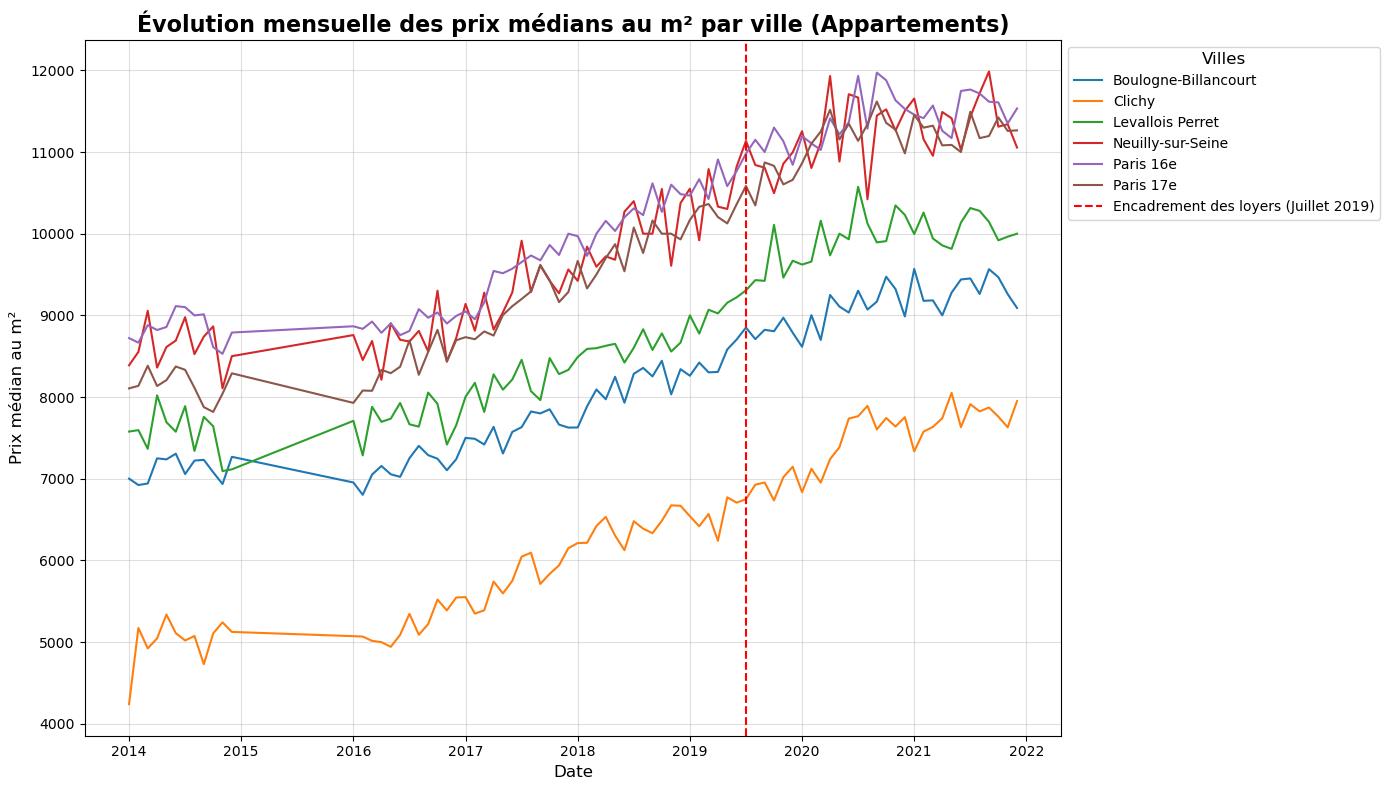

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

appartements = data_mut_ouest_et_insee[data_mut_ouest_et_insee['libtypbien'] == 'UN APPARTEMENT']


appartements['datemut'] = pd.to_datetime(appartements['datemut'])


appartements['annee'] = appartements['datemut'].dt.year
appartements['mois'] = appartements['datemut'].dt.month


stats_mensuelles = appartements.groupby(['annee', 'mois', 'nom_ville'])['prix_m2'].agg(['mean', 'median', 'std']).reset_index()


stats_mensuelles['date'] = stats_mensuelles['annee'] + (stats_mensuelles['mois'] - 1) / 12

plt.figure(figsize=(14, 8))
for ville in stats_mensuelles['nom_ville'].unique():
    subset = stats_mensuelles[stats_mensuelles['nom_ville'] == ville]
    plt.plot(subset['date'], subset['median'], label=ville)

plt.axvline(x=2019 + 6/12, color='red', linestyle='--', linewidth=1.5, label="Encadrement des loyers (Juillet 2019)")


plt.title("Évolution mensuelle des prix médians au m² par ville (Appartements)", fontsize=16, fontweight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Prix médian au m²", fontsize=12)
plt.legend(title="Villes", fontsize=10, title_fontsize=12, loc='upper left', bbox_to_anchor=(1, 1))  # Légende à l'extérieur
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()



In [ ]:

appartements = data_mut_ouest_et_insee[data_mut_ouest_et_insee['libtypbien'] == 'UN APPARTEMENT']


date_limite = '2019-07-01'
periode_avant = '2018-07-01'
periode_apres = '2020-06-30'


avant = appartements[(appartements['datemut'] >= periode_avant) & (appartements['datemut'] < date_limite)]
apres = appartements[(appartements['datemut'] >= date_limite) & (appartements['datemut'] <= periode_apres)]


stats_avant = avant.groupby('nom_ville')['prix_m2'].agg(['mean', 'median']).rename(columns={"mean": "moyenne_avant", "median": "mediane_avant"})
stats_apres = apres.groupby('nom_ville')['prix_m2'].agg(['mean', 'median']).rename(columns={"mean": "moyenne_apres", "median": "mediane_apres"})

comparaison = pd.concat([stats_avant, stats_apres], axis=1)

print("Comparaison des prix moyens et médians avant et après juillet 2019 (Appartements uniquement) :")
print(comparaison)




Comparaison des prix moyens et médians avant et après juillet 2019 (Appartements uniquement) :
                      moyenne_avant  mediane_avant  moyenne_apres  \
nom_ville                                                           
Boulogne-Billancourt    8311.337060    8357.309606    8843.814574   
Clichy                  6361.214949    6548.387097    6840.572441   
Levallois Perret        8753.179906    8861.671123    9451.849022   
Neuilly-sur-Seine      10304.586380   10363.636364   10957.744024   
Paris 16e              10439.897295   10526.315789   11204.262803   
Paris 17e               9855.030995   10170.227273   10747.474679   

                      mediane_apres  
nom_ville                            
Boulogne-Billancourt    8888.888889  
Clichy                  7095.238095  
Levallois Perret        9780.000000  
Neuilly-sur-Seine      11084.337349  
Paris 16e              11131.006865  
Paris 17e              10966.304348  


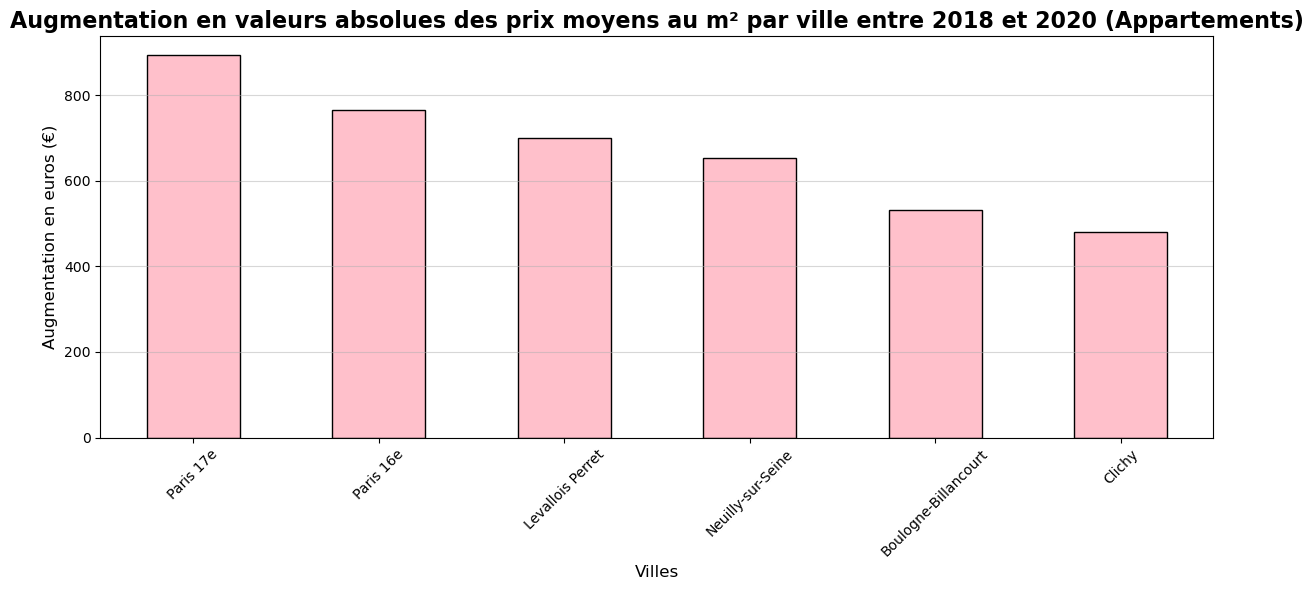

In [ ]:
import matplotlib.pyplot as plt


appartements = data_mut_ouest_et_insee[data_mut_ouest_et_insee['libtypbien'] == 'UN APPARTEMENT']


date_limite = '2019-07-01'
periode_avant = '2018-07-01'
periode_apres = '2020-06-30'


avant = appartements[(appartements['datemut'] >= periode_avant) & (appartements['datemut'] < date_limite)]
apres = appartements[(appartements['datemut'] >= date_limite) & (appartements['datemut'] <= periode_apres)]

stats_avant = avant.groupby('nom_ville')['prix_m2'].mean().rename("moyenne_avant")
stats_apres = apres.groupby('nom_ville')['prix_m2'].mean().rename("moyenne_apres")


comparaison = pd.concat([stats_avant, stats_apres], axis=1)


comparaison['augmentation_absolue'] = comparaison['moyenne_apres'] - comparaison['moyenne_avant']

comparaison_triee = comparaison.sort_values(by='augmentation_absolue', ascending=False)


plt.figure(figsize=(12, 6))
comparaison_triee['augmentation_absolue'].plot(kind='bar', color='pink', edgecolor='black')


plt.title("Augmentation en valeurs absolues des prix moyens au m² par ville entre 2018 et 2020 (Appartements)", fontsize=16, fontweight='bold')
plt.xlabel("Villes", fontsize=12)
plt.ylabel("Augmentation en euros (€)", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.grid(axis='y', alpha=0.5)
plt.tight_layout()
plt.show()




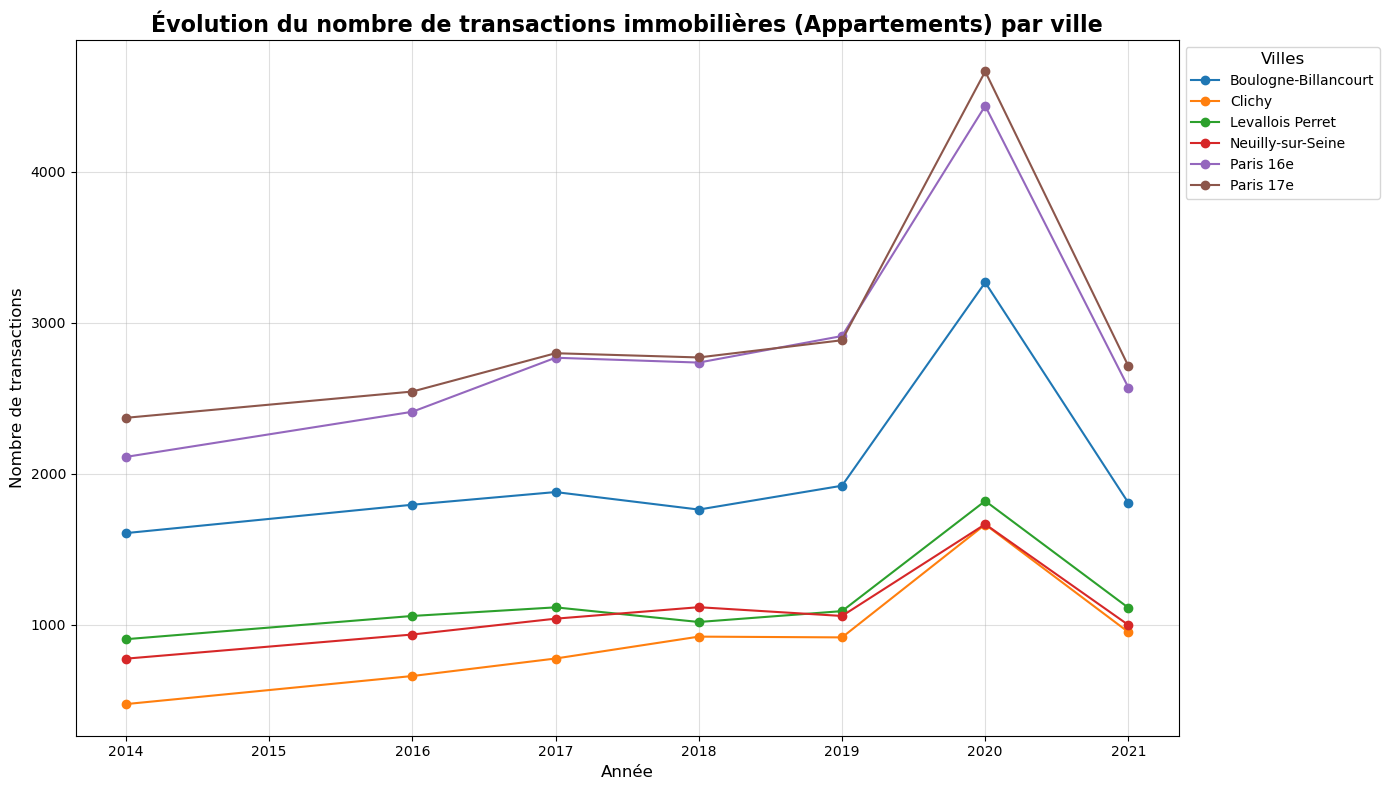

In [ ]:

appartements = data_mut_ouest_et_insee[data_mut_ouest_et_insee['libtypbien'] == 'UN APPARTEMENT']

# Comptage du nombre de transactions par ville et par année pour les appartements
transactions_par_ville = appartements.groupby(['annee', 'nom_ville']).size().reset_index(name='nombre_transactions')


plt.figure(figsize=(14, 8))
for ville in transactions_par_ville['nom_ville'].unique():
    subset = transactions_par_ville[transactions_par_ville['nom_ville'] == ville]
    plt.plot(subset['annee'], subset['nombre_transactions'], label=ville, marker='o')

plt.title("Évolution du nombre de transactions immobilières (Appartements) par ville", fontsize=16, fontweight='bold')
plt.xlabel("Année", fontsize=12)
plt.ylabel("Nombre de transactions", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title="Villes", fontsize=10, title_fontsize=12, loc='upper left', bbox_to_anchor=(1, 1))  # Légende à l'extérieur
plt.grid(alpha=0.4)
plt.tight_layout()  # Ajustement pour éviter le chevauchement
plt.show()


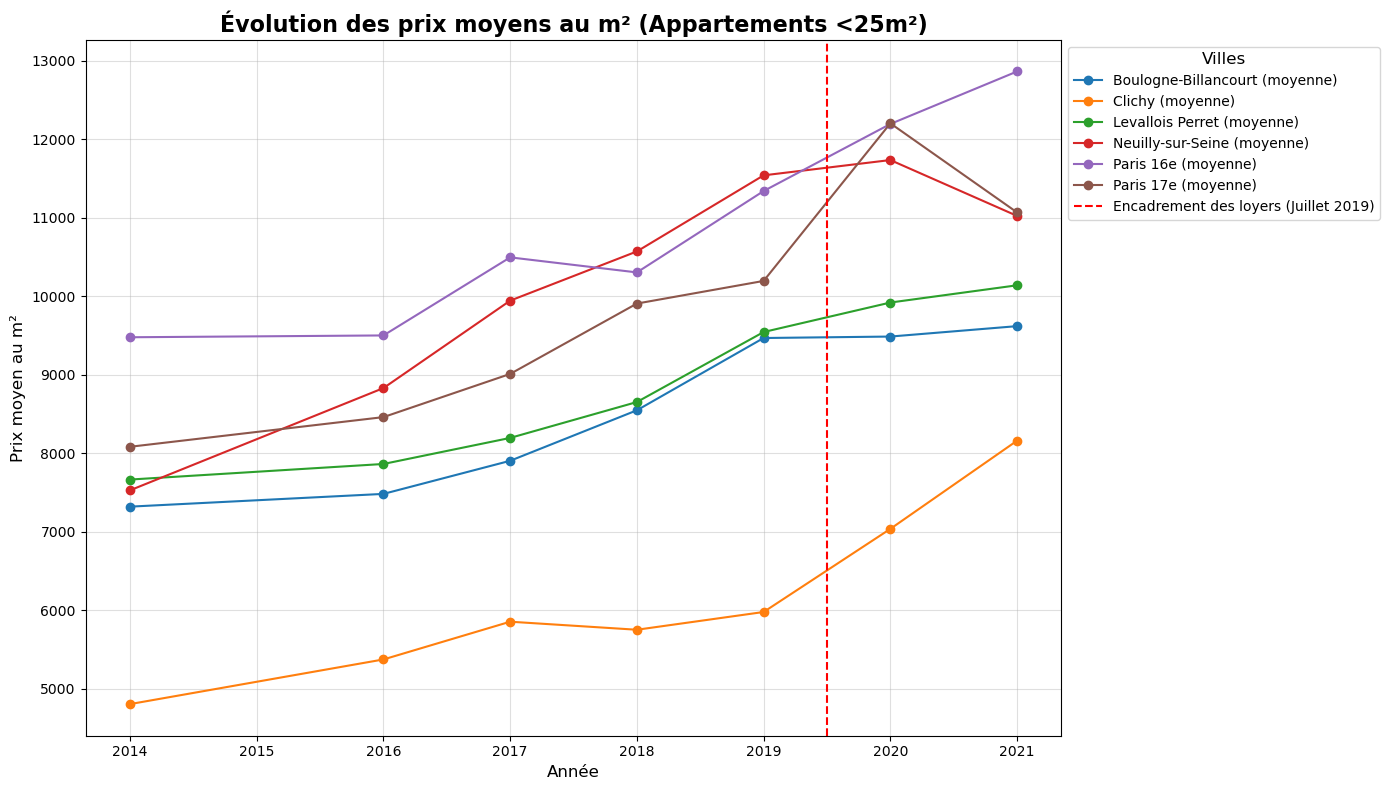

In [ ]:

plt.figure(figsize=(14, 8))
for ville in prix_par_ville['nom_ville'].unique():
    subset = prix_par_ville[prix_par_ville['nom_ville'] == ville]
    plt.plot(subset['annee'], subset['mean'], label=f"{ville} (moyenne)", marker='o')


plt.axvline(x=2019.5, color='red', linestyle='--', linewidth=1.5, label="Encadrement des loyers (Juillet 2019)")


plt.title("Évolution des prix moyens au m² (Appartements <25m²)", fontsize=16, fontweight='bold')
plt.xlabel("Année", fontsize=12)
plt.ylabel("Prix moyen au m²", fontsize=12)
plt.legend(title="Villes", fontsize=10, title_fontsize=12, loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()



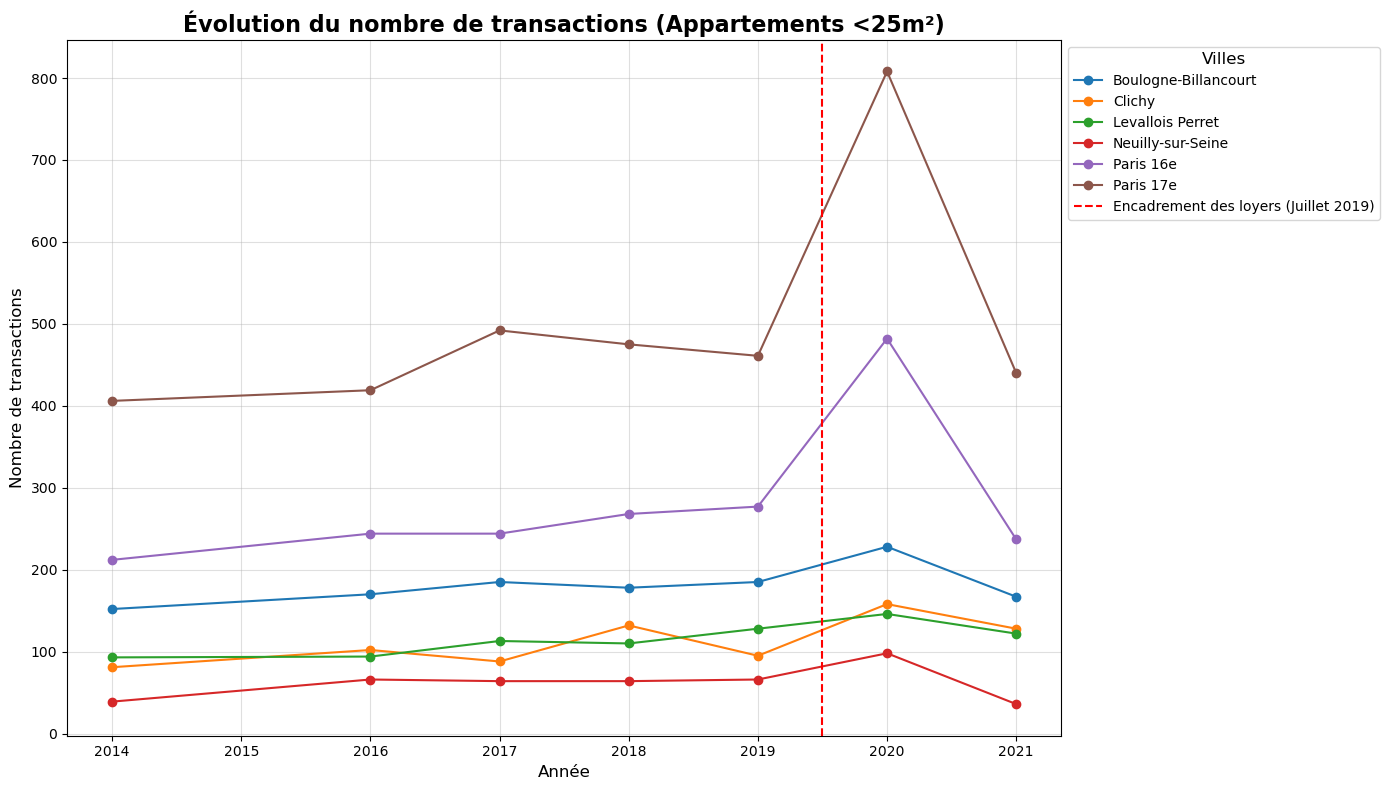

In [ ]:

plt.figure(figsize=(14, 8))
for ville in transactions_petits['nom_ville'].unique():
    subset = transactions_petits[transactions_petits['nom_ville'] == ville]
    plt.plot(subset['annee'], subset['nombre_transactions'], label=ville, marker='o')

plt.axvline(x=2019.5, color='red', linestyle='--', linewidth=1.5, label="Encadrement des loyers (Juillet 2019)")


plt.title("Évolution du nombre de transactions (Appartements <25m²)", fontsize=16, fontweight='bold')
plt.xlabel("Année", fontsize=12)
plt.ylabel("Nombre de transactions", fontsize=12)
plt.legend(title="Villes", fontsize=10, title_fontsize=12, loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()

# Differences in differences

**1. DID naïf**

On cherche à appliquer le modèle du difference in differences (DID) à deux ensembles : l'Ouest parisien et le Sud parisien. Commençons par l'ouest. On se réfère au modèle mathématique du DID présenté sur la page [Wikipédia dédiée] en anglais. 

On sépare notre cluster en un groupe "contrôle" (villes en bordures du périphérique) et un groupe "traitement" (arrondissements parisiens en bordure du périphérique). 

In [ ]:
crtl_ouest = data_mut_ouest_et_insee[data_mut_ouest_et_insee['coddep']=='92']
trtm_ouest = data_mut_ouest_et_insee[data_mut_ouest_et_insee['coddep']=='75']

On va réaliser un DID sur le prix moyen au mètre carré, en acceptant la supposition que la tendance d'évolution dans le temps des deux groupes est similaire. 

In [ ]:
crtl_ouest['prix_m2'] = crtl_ouest['valeurfonc'] / crtl_ouest['stot']
trtm_ouest['prix_m2'] = trtm_ouest['valeurfonc'] / trtm_ouest['stot']

/opt/conda/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


On sépare nos observations selon qu'elles sont avant ou après le 1 juillet 2019, date de l'entrée en vigueur de l'encadrement des loyers. Puis on calcule les valeurs de notre variable d'intérêt pour le groupe contrôle avant et après traitement.

In [ ]:
cutoff_date = pd.to_datetime("2019-07-01")

crtl_ouest['periode'] = crtl_ouest['datemut'].apply(
    lambda x: 0 if x < cutoff_date else 1
)
s1 = crtl_ouest[crtl_ouest['periode']==0]['prix_m2'].mean()
s2 = crtl_ouest[crtl_ouest['periode']==1]['prix_m2'].mean()

/opt/conda/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


On refait la même chose pour le groupe traitement avant et après traitement.

In [ ]:
trtm_ouest['periode'] = trtm_ouest['datemut'].apply(
    lambda x: 0 if x < cutoff_date else 1
)
p1 = trtm_ouest[trtm_ouest['periode']==0]['prix_m2'].mean()
p2 = trtm_ouest[trtm_ouest['periode']==1]['prix_m2'].mean()

/opt/conda/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


On peut désormais réaliser un graphique montrant cette différence de différence :

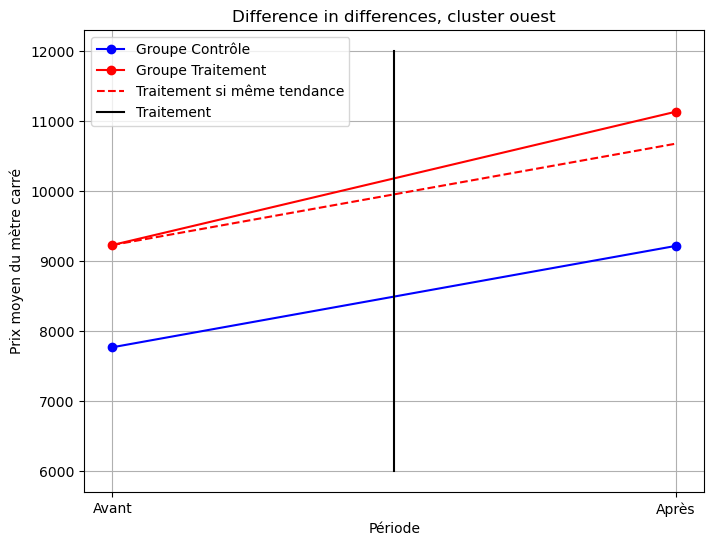

In [ ]:
periode = ['Avant', 'Après']

# Création du graphique
plt.figure(figsize=(8, 6))

plt.plot(periode, [s1, s2], marker='o', label='Groupe Contrôle', color='blue')
plt.plot(periode, [p1, p2], marker='o', label='Groupe Traitement', color='red')
plt.plot(periode, [p1, p1 + (s2 - s1)], linestyle='--', label='Traitement si même tendance', color='red')
plt.plot([0.5, 0.5], [6000,12000], label='Traitement', color='black')


plt.xlabel('Période')
plt.ylabel('Prix moyen du mètre carré')
plt.title('Difference in differences, cluster ouest')
plt.legend()

# Afficher le graphique
plt.grid(True)
plt.show()

Et la valeur numérique : 

In [ ]:
print((p2-p1)-(s2-s1))

456.5430822431563


On peut réaliser le même travail pour le cluster sud. 

In [ ]:
crtl_sud = data_mut_sud_et_insee[data_mut_sud_et_insee['coddep'].isin(['92', '94'])]
trtm_sud = data_mut_sud_et_insee[data_mut_sud_et_insee['coddep']=='75']

In [ ]:
crtl_sud['prix_m2'] = crtl_sud['valeurfonc'] / crtl_sud['stot']
trtm_sud['prix_m2'] = trtm_sud['valeurfonc'] / trtm_sud['stot']

/opt/conda/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/conda/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [ ]:
cutoff_date = pd.to_datetime("2019-07-01")

crtl_sud['periode'] = crtl_sud['datemut'].apply(
    lambda x: 0 if x < cutoff_date else 1
)
s1 = crtl_sud[crtl_sud['periode']==0]['prix_m2'].mean()
s2 = crtl_sud[crtl_sud['periode']==1]['prix_m2'].mean()

/opt/conda/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [ ]:
trtm_sud['periode'] = trtm_sud['datemut'].apply(
    lambda x: 0 if x < cutoff_date else 1
)
p1 = trtm_sud[trtm_sud['periode']==0]['prix_m2'].mean()
p2 = trtm_sud[trtm_sud['periode']==1]['prix_m2'].mean()

/opt/conda/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


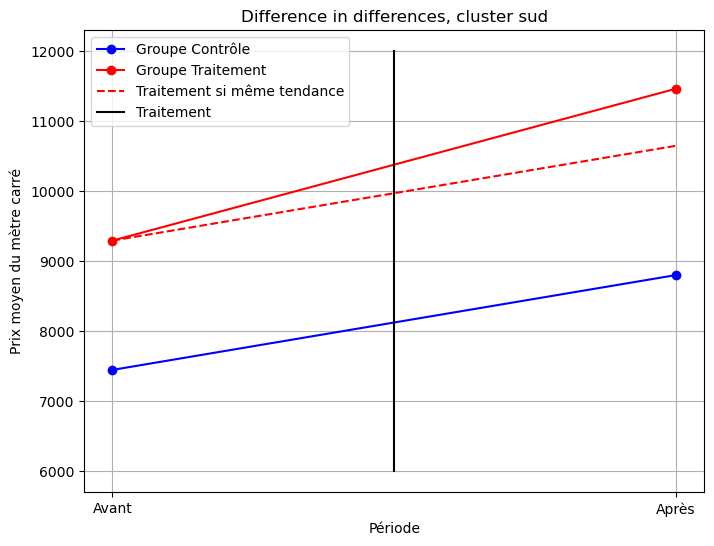

In [ ]:
periode = ['Avant', 'Après']

# Création du graphique
plt.figure(figsize=(8, 6))

plt.plot(periode, [s1, s2], marker='o', label='Groupe Contrôle', color='blue')
plt.plot(periode, [p1, p2], marker='o', label='Groupe Traitement', color='red')
plt.plot(periode, [p1, p1 + (s2 - s1)], linestyle='--', label='Traitement si même tendance', color='red')
plt.plot([0.5, 0.5], [6000,12000], label='Traitement', color='black')


plt.xlabel('Période')
plt.ylabel('Prix moyen du mètre carré')
plt.title('Difference in differences, cluster sud')
plt.legend()

# Afficher le graphique
plt.grid(True)
plt.show()

In [ ]:
print((p2-p1)-(s2-s1))

814.9949305988293


Ces deux résultats sont très contre-intuitifs : si l'hypothèse de même tendance tient, l'encadrement des loyers est donc corrélé à une augmentation du prix moyen au mètre carré.


In [ ]:
crtl_ouest = crtl_ouest[crtl_ouest['anneemut'].isin(["2021", '2020', '2019'])]
trtm_ouest = trtm_ouest[trtm_ouest['anneemut'].isin(["2021", '2020', '2019'])]

**2. Meilleure modélisation de la tendance**

L'une des raisons de nos résultats surprenants peut résider dans la limite principale du DID, qui est l'hypothèse de tendance similaire. Autrement dit, on observe directement s1, s2, p1, p2, donc il n'y a rien à changer de ce côté. Par contre, on observe pas $Q$, le prix moyen du mètre carré du groupe traitement s'il n'y avait pas eu de traitement. C'est ici qu'il y a une piste d'amélioration. 

Toute l'idée du modèle DID est de prédire l'évolution projetée du groupe traitement à partir de l'évolution observée du groupe contrôle. Mais on peut essayer une autre méthode, d'autant qu'on dispose de nombreuses variables INSEE qu'on n'a pas du tout exploitées. Pour reprendre le modèle de Wikipedia, on a $ Q = \gamma_{s(2)} + \lambda_{2} + \epsilon_{2}$. Dans le cadre du DID, on a fait comme si le $\lambda_t$ était purement indépendant des caractéristiques de chaque groupe. Mais on peut envisager les choses différement : on veut prédire $Q$ à partir des variables INSEE dont on dispose,  donc on veut $\lambda_t = X^T\beta$, où $X$ comprendra certaines variables INSEE. 

Comment déterminer ce $\beta$ ? L'objectif est d'obtenir la meilleure prédiction du prix moyen au mètre carré, sachant le jeu $(X_i, Y_i)_{i = 1, ..., n}$ et l'observation $Y_{n+1}$. On peut donc recourir à un estimateur LASSO. 

On ne peut pas simplement sélectionner toutes les variables INSEE, sinon on aurait une parfaite collinéarité entre certaines de nos covariables (par exemple, entre le nombre de femmes, le nombre d'hommes et le nombre d'habitants).

De plus, presque toutes les variables INSEE sont des quantités, et non des taux en proportion de la population de l'IRIS. En conséquence, la densité dans un IRIS peut brouiller l'effet d'une variable sur le prix moyen au mètre carré. On va donc commencer par forger les covariables que l'on souhaite utiliser : des taux non parfaitement collinéaires entre eux.

In [ ]:
data_mut_ouest_et_insee['prix_m2'] = data_mut_ouest_et_insee['valeurfonc'] / data_mut_ouest_et_insee['stot']
data_mut_ouest_et_insee['prop_h'] = data_mut_ouest_et_insee['P_H1564'] / data_mut_ouest_et_insee['P_POP1564']
data_mut_ouest_et_insee['tx_chom'] = data_mut_ouest_et_insee['P_CHOM1564'] / data_mut_ouest_et_insee['P_ACT1564']
data_mut_ouest_et_insee['prop_ht_diplome'] = data_mut_ouest_et_insee['C_ACT1564_CS3'] / data_mut_ouest_et_insee['P_ACT1564']
data_mut_ouest_et_insee['prop_maison'] = data_mut_ouest_et_insee['P_MAISON'] / data_mut_ouest_et_insee['P_LOG']
data_mut_ouest_et_insee['prop_res_princ'] = data_mut_ouest_et_insee['P_RP'] / data_mut_ouest_et_insee['P_LOG']

list_covar = ['prop_h', 'tx_chom',"prop_ht_diplome", "prop_maison", "prop_res_princ"] #"DISP_MED"

On va également s'assurer de pouvoir utiliser le revenu médian (il faut transformer la variable en type numérique).

In [ ]:
print(len(data_mut_ouest_et_insee))
def est_un_nombre(valeur):
    try:
        a = str(valeur).replace(',', ".")
        float(a)
        return True
    except ValueError:
        return False

data_mut_ouest_et_insee = data_mut_ouest_et_insee[data_mut_ouest_et_insee['DISP_MED'].apply(est_un_nombre)]
print(len(data_mut_ouest_et_insee))

77368


In [ ]:
data_mut_ouest_et_insee['DISP_MED'] = data_mut_ouest_et_insee['DISP_MED'].astype(float)

On peut maintenant créer notre jeux de données $(X_i, Y_i)_{i=1,...,n}$. Puisqu'on veut une estimation de $Q$ s'il n'y avait pas eu le traitement, on doit exclure les observations réalisées après traitement. On doit également exclure les observations du groupe contrôle. Le groupe contrôle ne sert en effet que dans le DID, pour avoir une estimation de $Q$. Mais si l'on veut prédire $Q$ à partir des données passées, mieux vaut ne garder que les donnnées des arrondissements parisiens.

In [ ]:
cutoff_date = pd.to_datetime("2019-07-01")

data_mut_ouest_et_insee['periode'] = data_mut_ouest_et_insee['datemut'].apply(
    lambda x: 0 if x < cutoff_date else 1
)

df_lasso_ouest = data_mut_ouest_et_insee[data_mut_ouest_et_insee['periode']==0]
df_lasso_ouest = df_lasso_ouest[df_lasso_ouest['coddep']=='75']
X = df_lasso_ouest[list_covar]
Y = df_lasso_ouest['prix_m2']

Et on va produire l'observation $X_{n+1}$ de nos covariables : puisque $Y_{n+1}$ correspond au prix *moyen* du mètre carré, $X_{n+1}$ doit représenter la variables de nos covariables pour les observations après traitement. 

In [ ]:
df_new_obs = data_mut_ouest_et_insee[data_mut_ouest_et_insee['periode']==1]
df_new_obs = df_new_obs[df_new_obs['coddep']=='75']
X_new = pd.DataFrame(df_new_obs[list_covar].mean()).T
Y_new_obs = df_new_obs['prix_m2'].mean()

In [ ]:
On sépare maintenant nos données en jeux d'entraînement et de test : 

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

On doit ensuite normaliser nos données.

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_new_scaled = scaler.transform(X_new)

In [ ]:
lasso_cv = LassoCV(cv=5, random_state=42)
lasso_cv.fit(X_train_scaled, Y_train)

LassoCV(cv=5, random_state=42)

On peut regarder le $R^2$ de la régression que l'on obtient avec cet estimateur LASSO. 

In [ ]:
print(lasso_cv.score(X_test_scaled, Y_test))

0.03671208357142741


La régression réalisée est donc extrêmement mauvaise (nos covariables sont très peu utiles pour prédire le prix du mètre carré). Regardons quand même la valeur qu'on obtient pour $Q$ : 

In [ ]:
Y_new = lasso_cv.predict(X_new_scaled)
print(Y_new)
print(Y_new_obs)

[9470.97751578]
11120.765751503604


Comparons avec le $Q$ obtenu dans le DID : 

In [ ]:
print(p1 + (s2 - s1))

10649.247279535302


Manifestement, le DID reste une meilleure méthode de projection de $Q$ que l'estimateur LASSO. 

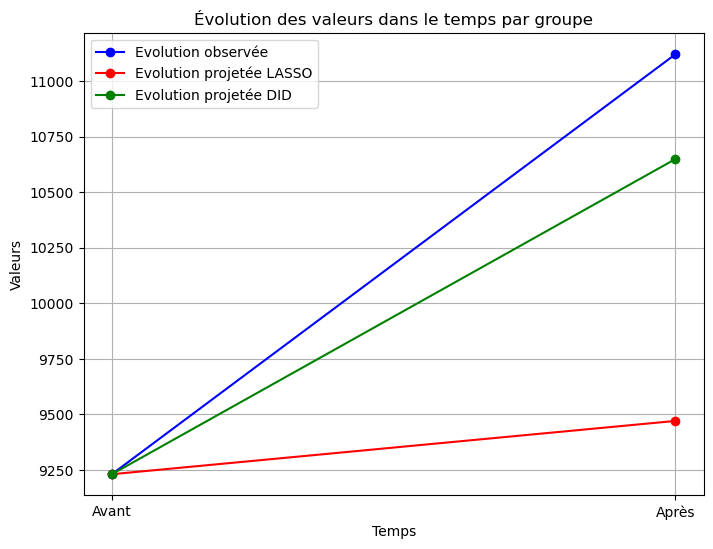

In [ ]:
import matplotlib.pyplot as plt

periode = ['Avant', 'Après']
dprt = df_lasso_ouest['prix_m2'].mean()

# Création du graphique
plt.figure(figsize=(8, 6))

# Tracer les valeurs du groupe 1
plt.plot(periode, [dprt, Y_new_obs ], marker='o', label='Evolution observée', color='blue')

# Tracer les valeurs du groupe 2
plt.plot(periode, [dprt, Y_new[0]], marker='o', label='Evolution projetée LASSO', color='red')
plt.plot(periode, [dprt, p1 + (s2 - s1)], marker='o', label='Evolution projetée DID', color='green')


# Ajouter des labels et un titre
plt.xlabel('Temps')
plt.ylabel('Valeurs')
plt.title('Évolution des valeurs dans le temps par groupe')
plt.legend()

# Afficher le graphique
plt.grid(True)
plt.show()


On va réaliser le même procédé pour le cluster sud. 

In [ ]:
data_mut_ouest_et_insee['prix_m2'] = data_mut_ouest_et_insee['valeurfonc'] / data_mut_ouest_et_insee['stot']
data_mut_ouest_et_insee['prop_h'] = data_mut_ouest_et_insee['P_H1564'] / data_mut_ouest_et_insee['P_POP1564']
data_mut_ouest_et_insee['tx_chom'] = data_mut_ouest_et_insee['P_CHOM1564'] / data_mut_ouest_et_insee['P_ACT1564']
data_mut_ouest_et_insee['prop_ht_diplome'] = data_mut_ouest_et_insee['C_ACT1564_CS3'] / data_mut_ouest_et_insee['P_ACT1564']
data_mut_ouest_et_insee['prop_maison'] = data_mut_ouest_et_insee['P_MAISON'] / data_mut_ouest_et_insee['P_LOG']
data_mut_ouest_et_insee['prop_res_princ'] = data_mut_ouest_et_insee['P_RP'] / data_mut_ouest_et_insee['P_LOG']

list_covar = ['prop_h', 'tx_chom',"prop_ht_diplome", "prop_maison", "prop_res_princ"]

In [ ]:
cutoff_date = pd.to_datetime("2019-07-01")

data_mut_ouest_et_insee['periode'] = data_mut_ouest_et_insee['datemut'].apply(
    lambda x: 0 if x < cutoff_date else 1
)

df_lasso_ouest = data_mut_ouest_et_insee[data_mut_ouest_et_insee['periode']==0]
df_lasso_ouest = df_lasso_ouest[df_lasso_ouest['coddep']=='75']
X = df_lasso_ouest[list_covar]
Y = df_lasso_ouest['prix_m2']

Les seuls résultats exploitables proviennent donc du DID : l'encadrement des loyers conduirait à une hausse du prix du mètre carré. Ce résultat n'est cependant pas complètement absurde : certaines études économiques ont montré que l'encadrement des loyers réduit l'offre de logements disponibles, ce qui peut avoir deux effets : 
- le loyer moyen augmente, ce qui encourage à investir plus dans l'immobilier dans la zone, et donc mène à une hausse des prix du mètre carré ; 
- face au rationnement de l'offre locative, les ménages souhaitant s'installer dans la zone se redirigent vers l'achat, conduisant à une hausse du prix du mètre carré. 

Il s'agît là de deux pistes d'explications, qu'il faudrait explorer. Quant au travail que nous avons réalisé, il ne s'avère finalement pas très concluant.